# PyGEM regional glacier change analysis

Brandon Tober, David Rounce<br>
Carnegie Mellon University<br>
Created: 03JAN2025<br><br>
Objective: Showcase how to regionally compile simulations and analyze the aggregated glacier change.

>**Note:** in this notebook, any PyGEM Python scripts that are called will be preceeded by ```!```. In Jupyter Notebook, the ```!``` character is used to execute shell commands directly from a notebook cell. When you prefix a command with ```!```, Jupyter sends it to the system's command-line shell for execution, instead of interpreting it as Python code. Command-line arguments are also bracketed (e.g., ```{arg}```), when passing Python variables to a command-line shell from within a Jupyter Notebook. If executing a given PyGEM script directly from one's terminal, remove the ```!``` character and brackets ```{}``` around arguments.
>
>**Also note:** some useful information for any PyGEM script can be displayed by running
```!script -h```

This notebook follows the notebooks *run_calibration.ipynb* and *run_simulation.ipynb*, assuming that a set of regional PyGEM simulations have been performed for RGI region 6 (Iceland) for GCM BCC-CSM2-MR, scenario ssp245 following **MCMC** calibration.

In [ ]:
### imports ###
import os, sys, glob
# pygem imports
import pygem.pygem_modelsetup as modelsetup
from pygem.setup.config import ConfigManager
# instantiate ConfigManager
config_manager = ConfigManager()
# read the config
pygem_prms = config_manager.read_config()   # NOTE: ensure that your root path in ~/PyGEM/config.yaml points to
                                            # the appropriate location. If any errors occur, check this first.

## Compile regional simulations
The first step is to aggregate/compile all simulations for the desired RGI region.  PyGEM's *postproc_compile_simulations.py* script can be used for this.

In [2]:
# take a look how to call the postproc_compile_simulations script:
!postproc_compile_simulations -h 

usage: postproc_compile_simulations [-h] -rgi_region01 RGI_REGION01
                                    [RGI_REGION01 ...] -gcm_name GCM_NAME
                                    [GCM_NAME ...]
                                    [-scenario SCENARIO [SCENARIO ...]]
                                    [-realization REALIZATION [REALIZATION ...]]
                                    [-gcm_startyear GCM_STARTYEAR]
                                    [-gcm_endyear GCM_ENDYEAR]
                                    [-sim_path SIM_PATH]
                                    [-option_calibration OPTION_CALIBRATION]
                                    [-option_bias_adjustment OPTION_BIAS_ADJUSTMENT]
                                    [-vars {glac_runoff_monthly,offglac_runoff_monthly,glac_acc_monthly,glac_melt_monthly,glac_refreeze_monthly,glac_frontalablation_monthly,glac_massbaltotal_monthly,glac_prec_monthly,glac_mass_monthly,glac_mass_annual,glac_area_annual} [{glac_runoff_monthly,offglac_runof

In [3]:
# define args
gcm = 'BCC-CSM2-MR'
scenario = 'ssp245'
region = 6  # Iceland
calib = 'MCMC'  # `MCMC` calibration opt
startyr = 2000  # simulations start year
endyr = 2100    # simulations end year

# which GCMs were processed in run_simulation.ipynb? modify if different options were run!
gcms = ['BCC-CSM2-MR', 'EC-Earth3-Veg', 'INM-CM5-0']
# and which scenarios?
scenarios=['ssp245','ssp370','ssp585']

In [4]:
# compile
!postproc_compile_simulations -rgi_region01 {region} -sim_climate_name {' '.join(gcms)} -sim_climate_scenario {' '.join(scenarios)} -sim_startyear {startyr} -sim_endyear {endyr} -option_calibration {calib} -ncores 3 > compile_log.txt

>**Note:** To properly pass our list of GCMs and scenarios to *postproc_compile_simulations.py*, we must join list items and form a space-delimited string  (hence, `' '.join(gcms)` and `' '.join(scenarios)`), which *postproc_compile_simulations.py* will in turn interpret as lists. *postproc_compile_simulations.py* is set up to parallelize across the number of regions and scenarios which are being compiled (for a maximum of <#regions> x <#scenarios>, hence `-ncores 3` above).
>
>To see a record of the metrics on simulations completed successfully, see *./compile_log.txt*. For a log of which glacier runs may failed, see `pygem_prms['root']/Output/simulations/fail-exceed_domain/` and `pygem_prms['root']/Output/simulations/failed/`.

In [5]:
%%bash
tail compile_log.txt

  - 567 of 568 glaciers (99.824%)
  - 11060.0 km2 of 11060.0 km2 (99.998%)
GCM: INM-CM5-0 
Glaciers successfully simulated:
  - 567 of 568 glaciers (99.824%)
  - 11060.0 km2 of 11060.0 km2 (99.998%)
Batch 0 runtime:	18.44 seconds
Batch 0 runtime:	18.83 seconds
Batch 0 runtime:	19.09 seconds
Total runtime: 19.67 seconds


The result of running *postproc_compile_simulations.py* will be an aggregated netcdf file for variable, stored within `pygem_prms['root']/Output/simulations/compile`

>**Note:**, for monthly variables (e.g. `glac_massbaltotal_monthly`) simulations are aggregated in 1000-glacier chunks to keep file sizes manageable.
>
>The cell above will aggregate all available variables for the specified batch of simulations. The `-vars` argument of PyGEMs *postproc_compile_simulations.py* script shows the variables which can can be aggregated across simulations. However, some of these are not standard outputs and are only stored when *run_simulations.py* is passed the `-export_extra_vars` flag, or when `['sim']['out']['export_extra_vars']` is set to `true` in *~/PyGEM/config.yaml*. If the variables desired to be aggregated are not specified, *postproc_compile_simulations.py* will default to aggregating all available variables which were stored across simulations.
>
>If only specific variables are required, these could have been passed as arguments (space-delimited), e.g. for compiling glacier mass, area, and runoff:

```bash
!postproc_compile_simulations -rgi_region01 {region} -sim_climate_name {' '.join(gcms)} -sim_climate_scenario {' '.join(scenarios)} -sim_startyear {startyr} -sim_endyear {endyr} -option_calibration {calib} -ncores 3  -vars glac_mass_monthly glac_area_annual glac_runoff_monthly
```

## Regional analysis

Regional analysis can now be completed for the variables of interest.

First, we'll plot regional timeseries of projected glacier area, mass, and runoff, showing the multi-GCM median and range.
Second, we'll plot histograms of the relative mass remaining for each scenario for the multi-GCM median.

### Median/Range of mass, area, runoff

In [6]:
# more imports
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from scipy.ndimage import uniform_filter    # for smoothing monthly runoff data

In [7]:
# here we define some dictionary objects to simplify plotting below
ds_vn_dict = {'mass_annual':'glac_mass_annual',
              'area_annual':'glac_area_annual',
              'runoff_fixed_monthly':'glac_runoff_monthly'}
rgi_reg_dict = {'all':'Global',
                'global':'Global',
                1:'Alaska',
                2:'W Canada & US',
                3:'Arctic Canada North',
                4:'Arctic Canada South',
                5:'Greenland Periphery',
                6:'Iceland',
                7:'Svalbard',
                8:'Scandinavia',
                9:'Russian Arctic',
                10:'North Asia',
                11:'Central Europe',
                12:'Caucasus & Middle East',
                13:'Central Asia',
                14:'South Asia West',
                15:'South Asia East',
                16:'Low Latitudes',
                17:'Southern Andes',
                18:'New Zealand',
                19:'Antarctic & Subantarctic'
                }
scenario_namedict = {
                    'ssp245':'SSP2-4.5',
                    'ssp370':'SSP3-7.0',
                    'ssp585':'SSP5-8.5'
                     }
scenario_colordict = {
                    'ssp245':'#1b9e77',
                    'ssp370':'#d95f02',
                    'ssp585':'#7570b3'
                    }

In [8]:
# specify where to look for results
agg_path = f"{pygem_prms['root']}/Output/simulations/compile/glacier_stats/"

# variables of interest
vns = ['mass_annual', 'area_annual', 'runoff_fixed_monthly']

# choose a year to normalize values to
normyear=2000

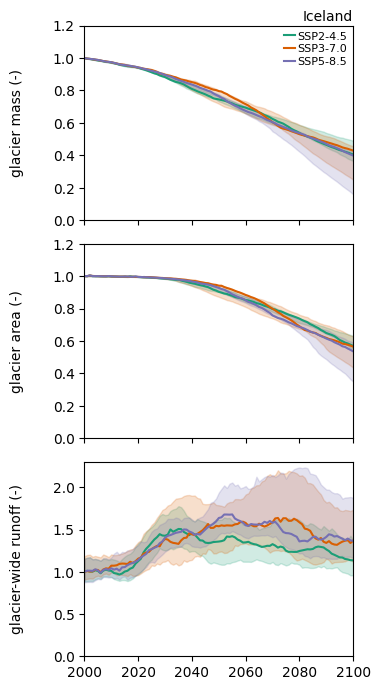

In [9]:
fig,ax = plt.subplots(3,figsize=(4,7),sharex=True)

# keep track of maxes to scale ylims later
maxes = []

for nvn, vn in enumerate(vns):
    # Dataset variable name
    ds_vn = ds_vn_dict[vn]
    # Filepath
    ds_fp = agg_path + '/' + ds_vn + '/' + str(region).zfill(2) + '/'
    
    # loop through scenarios combinations
    # for gcm in gcms:
    for ssp in scenarios:
        # get list of files to open
        ds_fns = glob.glob(f'{ds_fp}/R{str(region).zfill(2)}_{ds_vn}_{ssp}*.nc')
        
        # check for batched outputs so we can aggregate them
        ds_fns_int = []                
        for i in ds_fns:
            if 'Batch' in i:
                ds_fns_int.append(int(i.split('-')[-2]))

        # Sort filenames
        if len(ds_fns_int) > 0:
            ds_fns = [x for _,x in sorted(zip(ds_fns_int, ds_fns))]

        # Load data (aggregate if necessary)
        for nfn, ds_fn in enumerate(ds_fns):
            if nfn == 0:
                ds = xr.open_dataset(ds_fn)
            else:
                ds_batch = xr.open_dataset(ds_fn)
                ds = xr.concat((ds, ds_batch), dim='glacier')
            models = ds.Climate_Model.values.tolist()

        # Aggregate data
        if 'annual' in ds_vn:
            ds_sum = ds.sum(dim='glacier')
            ds_median = ds_sum.median(dim='model')
            ds_min = ds_sum.min(dim='model')
            ds_max = ds_sum.max(dim='model')
            time_values = ds.time.values
            
        elif 'monthly' in ds_vn:             
            ds_sum = ds.resample(time='YE').sum('time').sum('glacier')     # resample to annual
            ds_median = ds_sum.median(dim='model')
            ds_min = ds_sum.min(dim='model')
            ds_max = ds_sum.max(dim='model')
            time_values = np.array([x.year for x in ds_sum.time.values])

        normyear_idx = np.where(time_values == normyear)[0][0]
        ds_median_vals = ds_median[ds_vn].values
        ds_min_vals = ds_min[ds_vn].values
        ds_max_vals = ds_max[ds_vn].values

        # Smooth runoff with 11-year running mean
        if 'runoff' in ds_vn:
            ds_median_vals = uniform_filter(ds_median_vals, size=(11))
            ds_min_vals = uniform_filter(ds_min_vals, size=(11))                
            ds_max_vals = uniform_filter(ds_max_vals, size=(11))                
        
        ax[nvn].plot(time_values, ds_median_vals / ds_median_vals[normyear_idx], c=scenario_colordict[ssp])

        # plot range
        ax[nvn].fill_between(time_values, 
                             ds_min_vals / ds_median_vals[normyear_idx], 
                             ds_max_vals / ds_median_vals[normyear_idx], 
                            color=scenario_colordict[ssp],
                            alpha=0.2)

        # get max
        if 'runoff' not in ds_vn:
            maxes.append(np.nanmax((ds_max_vals / ds_median_vals[normyear_idx])))

    # Add Labels
    ylabel_norm = ds[ds_vn].long_name + ' (-)'
    ax[nvn].set_ylabel(ylabel_norm, size=10, labelpad=15)
    # set consistent ylabel coords
    ax[nvn].get_yaxis().set_label_coords(-0.225,0.5)

# get ylims for panels - round up slightly for max, lower limit will be hardcoded to 0
ymax = max(maxes)
ymax = .2*np.round(ymax/.2) + .2
for nvn, vn in enumerate(vns):
    if 'runoff' in vn:
        ymax = ax[nvn].get_ylim()[1]
    ax[nvn].set_ylim([0,ymax])

# Legend
for ssp in scenarios:
    ax[0].plot([],[],color = scenario_colordict[ssp] , label = scenario_namedict[ssp])
ax[0].text(1, 1.01, rgi_reg_dict[region], size=10, horizontalalignment='right', 
            verticalalignment='bottom', transform=ax[0].transAxes)
ax[0].legend(loc='upper right', fontsize=8, ncol=1, columnspacing=0.5, labelspacing=0.25, 
                handlelength=1, handletextpad=0.25, borderpad=0, frameon=False)

# xlims
ax[0].set_xlim([2000,2100])

fig.tight_layout()

### Regional histograms of median mass change

Text(0.5, 0, 'Mass at 2100 relative to 2000')

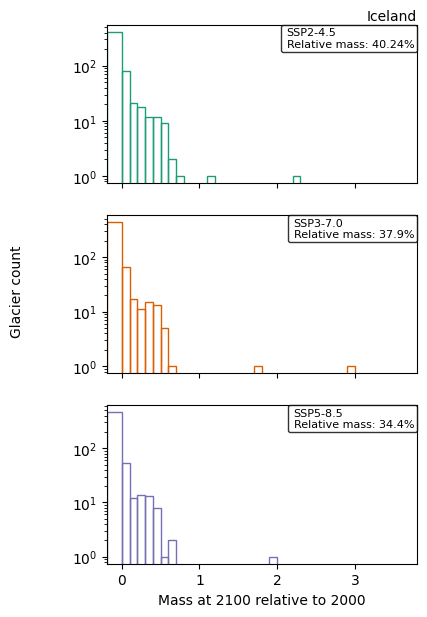

In [10]:
# create histogram of mass at 2100 / mass at 2000
nbins = 20
yoi=2100

fig,ax = plt.subplots(3,figsize=(4,7),sharex=True)

# Dataset variable name
ds_vn = ds_vn_dict['mass_annual']
ds_fp = agg_path + '/' + ds_vn + '/' + str(region).zfill(2) + '/'

# instantiate lists to hold relative perglacier mass
relative_mass_perglac = []
relative_mass_perglac_rounce = []

# loop through scenarios
for nscenario,ssp in enumerate(scenarios):
    ds_fns = glob.glob(ds_fp + 'R' + str(region).zfill(2) + '_glac_mass_annual_' + ssp + '*.nc')

    if len(ds_fns)==0:
        continue

    # read in xarray dataset
    ds = xr.open_dataset(ds_fns[0])
    # take median values for each glacier across all climate models
    ds_med = ds.median(dim='model')
    # also sum to get total remaining mass
    ds_med_sum = ds_med.sum(dim='glacier')

    # get indices of timesteps of interest
    idx0 = np.where(ds.time.values==2000)[0][0]
    idx1 = np.where(ds.time.values==yoi)[0][0]

    # get relative mass for each glacier
    rel_mass = ds_med[ds_vn].isel(time=idx1).values / ds_med[ds_vn].isel(time=idx0).values

    relative_mass_perglac.append(rel_mass)

    # fake plot to put info in legend
    ax[nscenario].plot([],[], ' ', label=f'{scenario_namedict[ssp]}\nRelative mass: {np.round(((ds_med_sum[ds_vn].values[idx1]/ds_med_sum[ds_vn].values[idx0])*100),2)}%')

# loop again to plot with same bins and extents
# get absolute max
max_ = max([np.nanmax(x) for x in relative_mass_perglac])
for nscenario,ssp in enumerate(scenarios):

    _, bins, _ = ax[nscenario].hist(relative_mass_perglac[nscenario], bins=np.arange(1e-5,max_,.1), facecolor='None', edgecolor=scenario_colordict[ssp], log=True)

    if nscenario==0:
        xlims = ax[nscenario].get_xlim()

    # make zero bin
    ax[nscenario].hist(relative_mass_perglac[nscenario], bins=[xlims[0],0], facecolor='None', edgecolor=scenario_colordict[ssp], log=True )

    ax[nscenario].set_xlim(xlims[0],bins[-1])

    ax[nscenario].legend(loc='upper right', fontsize=8, ncol=1, columnspacing=0.5, labelspacing=0.25, 
                handlelength=0, handletextpad=0.25, borderpad=0.25, borderaxespad=0, edgecolor='k', frameon=True, bbox_to_anchor=(1, 1))


# set lower ylim to zero
ax[0].text(1, 1.01, rgi_reg_dict[region], size=10, horizontalalignment='right', 
            verticalalignment='bottom', transform=ax[0].transAxes)
ax[0].text(-0.1, 0.5, 'Glacier count', size=10, horizontalalignment='center', 
            verticalalignment='center', rotation=90, transform=fig.transFigure)
ax[-1].set_xlabel(f'Mass at {yoi} relative to 2000')

### Plot original area vs. relative mass remaining at 2100

This study is focusing on 568 glaciers in region [6]


(0.0, 1.0)

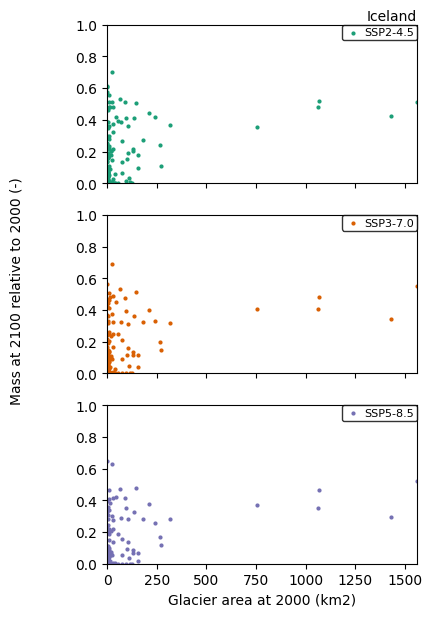

In [11]:
fig,ax = plt.subplots(3,figsize=(4,7),sharex=True,sharey=True)

s=4 # scatter plot marker size

# Dataset variable name
ds_vn = ds_vn_dict['mass_annual']
ds_fp = agg_path + '/' + ds_vn + '/' + str(region).zfill(2) + '/'

# get rgi glacier table for region
main_glac_rgi_all = modelsetup.selectglaciersrgitable(rgi_regionsO1=[region], 
                                                    rgi_regionsO2='all', rgi_glac_number='all', 
                                                    glac_no=None)
rgiids = main_glac_rgi_all.RGIId.values.tolist()
area = main_glac_rgi_all.Area

# loop through scenarios
for nscenario,ssp in enumerate(scenarios):
    # instantiate list to hold area in case ds is not sorted by idx
    area_ = []

    ds_fns = glob.glob(ds_fp + 'R' + str(region).zfill(2) + '_glac_mass_annual_' + ssp + '*.nc')

    if len(ds_fns)==0:
        continue

    # read in xarray dataset
    ds = xr.open_dataset(ds_fns[0])
    # take median values for each glacier across all climate models
    ds_med = ds.median(dim='model')
    # also sum to get total remaining mass
    ds_med_sum = ds_med.sum(dim='glacier')

    # get indices of timesteps of interest
    idx0 = np.where(ds.time.values==2000)[0][0]
    idx1 = np.where(ds.time.values==yoi)[0][0]

    # get relative mass for each glacier
    relative_mass_perglac = ds_med[ds_vn].isel(time=idx1).values / ds_med[ds_vn].isel(time=idx0).values

    rgiids_ = ds.RGIId.values.tolist()
    for id in rgiids_:
        ind = rgiids.index(id)
        area_.append(area[ind])

    ax[nscenario].scatter(area_, relative_mass_perglac, label=scenario_namedict[ssp], color=scenario_colordict[ssp], s=s)

    # hline at 1
    ax[nscenario].axhline(y=1, c='k', ls=':', lw=.5)

    ax[nscenario].legend(loc='upper right', fontsize=8, ncol=1, columnspacing=0.5, labelspacing=0.25, 
                handlelength=1.5, handletextpad=0.25, borderpad=.25, borderaxespad=0, edgecolor='k', frameon=True)

ax[0].text(1, 1.01, rgi_reg_dict[region], size=10, horizontalalignment='right', 
            verticalalignment='bottom', transform=ax[0].transAxes)
ax[0].text(-0.1, 0.5, f'Mass at {yoi} relative to 2000 (-)', size=10, horizontalalignment='center', 
            verticalalignment='center', rotation=90, transform=fig.transFigure)
ax[-1].set_xlabel('Glacier area at 2000 (km2)')

ax[0].set_xlim([0,max(area_)])
ax[0].set_ylim([0,1])

## Next
These examples simply serve to demonstrate how to work with PyGEMs compiled simulations and perform some regional analyses. Feel free to further experiment with additional plotting/analyses of your own!